## scikit-learn digits dataset Auto-Encoder example

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.GaussianKernel import GaussianKernel, GaussianKernel2, GaussianKernel3

# or copy and paste the definition of `GaussianKernel` here.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
digits = load_digits()
X, y = digits.data, digits.target
X[:5]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
         15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
          8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
          5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
          1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
          0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  12.,  13.,   5.,   0.,   0.,   0.,   0.,   0.,
         11.,  16.,   9.,   0.,   0.,   0.,   0.,   3.,  15.,  16.,   6.,
          0.,   0.,   0.,   7.,  15.,  16.,  16.,   2.,   0.,   0.,   0.,
          0.,   1.,  16.,  16.,   3.,   0.,   0.,   0.,   0.,   1.,  16.,
         16.,   6.,   0.,   0.,   0.,   0.,   1.,  16.,  16.,   6.,   0.,
          0.,   0.,   0.,   0.,  11.,  16.,  10.,   0.,   0.],
       [  0.,   0.,   0.,   4.,  15.,  12.,   0.,   0.,   0.,   0.,   3.,
         16.,  15.,  14.,   0.,   0.,   0.,   0.,   8.,  13.

In [5]:
X = X.reshape((X.shape[0], -1))
X[:5]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
         15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
          8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
          5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
          1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
          0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  12.,  13.,   5.,   0.,   0.,   0.,   0.,   0.,
         11.,  16.,   9.,   0.,   0.,   0.,   0.,   3.,  15.,  16.,   6.,
          0.,   0.,   0.,   7.,  15.,  16.,  16.,   2.,   0.,   0.,   0.,
          0.,   1.,  16.,  16.,   3.,   0.,   0.,   0.,   0.,   1.,  16.,
         16.,   6.,   0.,   0.,   0.,   0.,   1.,  16.,  16.,   6.,   0.,
          0.,   0.,   0.,   0.,  11.,  16.,  10.,   0.,   0.],
       [  0.,   0.,   0.,   4.,  15.,  12.,   0.,   0.,   0.,   0.,   3.,
         16.,  15.,  14.,   0.,   0.,   0.,   0.,   8.,  13.

In [6]:
X_sc = X / 16.0
X_sc.shape

(1797, 64)

In [7]:
X_sc

array([[ 0.    ,  0.    ,  0.3125, ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.625 ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  1.    ,  0.5625,  0.    ],
       ..., 
       [ 0.    ,  0.    ,  0.0625, ...,  0.375 ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.125 , ...,  0.75  ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.625 , ...,  0.75  ,  0.0625,  0.    ]])

In [8]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [9]:
y_cat = to_categorical(y)
y_cat

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### create model

In [10]:
'''
chose landmarks on input data
pick 10 data each digit
'''
np.random.seed(0)
num_lm0 = 20
num_lm = num_lm0 * 10
init_list = []
for ii in range(10):
    init_wgt0 = X_sc[y==ii]
    init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
                np.random.normal(scale=0.01, size=num_lm0*64).reshape(num_lm0, 64)
    init_list.append(init_wgt0)
init_wgt = np.vstack(init_list)
init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]
init_wgt.shape

(200, 64)

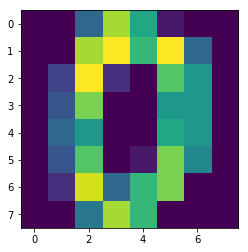

In [11]:
plt.imshow(X[0].reshape((8,8)))

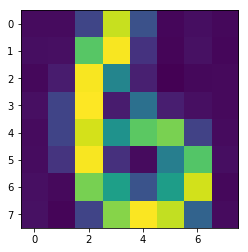

In [12]:
plt.imshow(init_wgt[0].reshape((8,8)))

In [13]:
np.random.seed(0)
num_lm = 200

def make_modelz():
    inp = Input(shape=(64,), name='inp')
    oup = inp
    
    oup_gk1 = GaussianKernel3(num_lm, 64, name='gkernel1', weights=[init_wgt, np.log(np.array([1./(2.*64*0.1)]))])(oup)
    model_gk1 = Model(inp, oup_gk1)
    
    oup = Dense(64, activation='sigmoid')(oup_gk1)
    
    model = Model(inp, oup)
    model.compile(loss='mse', optimizer='adam')
    
    return {
        'model': model,
        'model_gk1': model_gk1,
        #'model_gk2': model_gk2,
        #'model_gk3': model_gk3,
    }

models = make_modelz()
model = models['model']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 64)                0         
_________________________________________________________________
gkernel1 (GaussianKernel3)   (None, 200)               12801     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                12864     
Total params: 25,665
Trainable params: 25,665
Non-trainable params: 0
_________________________________________________________________


### train

In [14]:
model.fit(X_sc, X_sc, verbose=0,
          batch_size=32,
          epochs=150)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### predict

In [15]:
y_pred = model.predict(X_sc, batch_size=32, verbose=1)
y_pred

1568/1797 [=========================>....] - ETA: 0s

array([[  4.55546658e-04,   1.15148770e-02,   3.02968860e-01, ...,
          6.88174739e-02,   2.62173521e-03,   9.18870966e-04],
       [  6.27526490e-04,   8.18802603e-03,   3.50152142e-02, ...,
          5.44835806e-01,   6.88936412e-02,   2.86579169e-02],
       [  8.24842835e-04,   8.50499980e-03,   3.26683708e-02, ...,
          9.36889112e-01,   5.93619764e-01,   1.19121308e-02],
       ..., 
       [  4.59317293e-04,   9.02513601e-03,   9.95120108e-02, ...,
          3.69748533e-01,   4.04559784e-02,   4.64105094e-03],
       [  4.25009755e-04,   5.25072310e-03,   1.75984144e-01, ...,
          7.21905768e-01,   4.78807203e-02,   9.45295207e-03],
       [  4.08426276e-04,   1.70705747e-02,   5.69925964e-01, ...,
          7.53592014e-01,   1.10441335e-01,   3.61668831e-03]], dtype=float32)

In [16]:
X_sc[0]

array([ 0.    ,  0.    ,  0.3125,  0.8125,  0.5625,  0.0625,  0.    ,
        0.    ,  0.    ,  0.    ,  0.8125,  0.9375,  0.625 ,  0.9375,
        0.3125,  0.    ,  0.    ,  0.1875,  0.9375,  0.125 ,  0.    ,
        0.6875,  0.5   ,  0.    ,  0.    ,  0.25  ,  0.75  ,  0.    ,
        0.    ,  0.5   ,  0.5   ,  0.    ,  0.    ,  0.3125,  0.5   ,
        0.    ,  0.    ,  0.5625,  0.5   ,  0.    ,  0.    ,  0.25  ,
        0.6875,  0.    ,  0.0625,  0.75  ,  0.4375,  0.    ,  0.    ,
        0.125 ,  0.875 ,  0.3125,  0.625 ,  0.75  ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.375 ,  0.8125,  0.625 ,  0.    ,  0.    ,  0.    ])

In [17]:
y_pred[0]

array([  4.55546658e-04,   1.15148770e-02,   3.02968860e-01,
         7.79057980e-01,   5.06327689e-01,   1.14557289e-01,
         1.86589211e-02,   9.13951360e-03,   4.57427319e-04,
         3.45693976e-02,   8.72284293e-01,   8.40156913e-01,
         6.85801089e-01,   8.47492516e-01,   1.70235902e-01,
         8.43734946e-03,   4.32512112e-04,   1.55272618e-01,
         9.24350441e-01,   1.49593025e-01,   5.50487414e-02,
         8.16624820e-01,   4.80538994e-01,   4.93729161e-03,
         4.79870272e-04,   2.33288080e-01,   7.06122160e-01,
         3.96772958e-02,   1.78709868e-02,   5.69726169e-01,
         6.04986668e-01,   2.05647084e-04,   2.67863070e-04,
         3.16142648e-01,   5.52187681e-01,   3.55550386e-02,
         1.57111771e-02,   5.61181188e-01,   5.29109180e-01,
         3.41523206e-04,   4.68525192e-04,   2.15395436e-01,
         7.07907379e-01,   3.01208626e-02,   4.87371571e-02,
         7.83920884e-01,   2.92971998e-01,   1.22454588e-03,
         6.14062417e-04,

### compare inputs and outputs

0


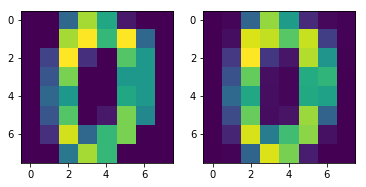

In [18]:
idx = 0
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

1


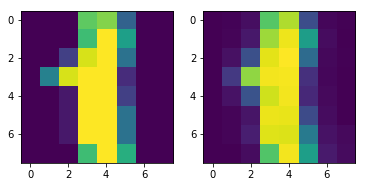

In [19]:
idx = 1
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

2


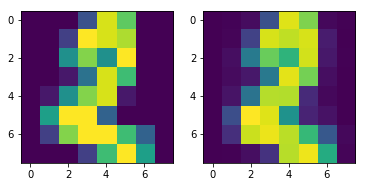

In [20]:
idx = 2
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

3


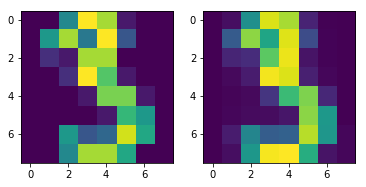

In [21]:
idx = 3
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

4


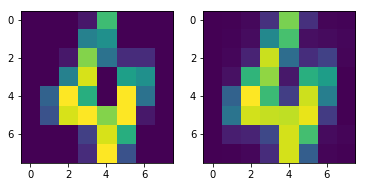

In [22]:
idx = 4
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

5


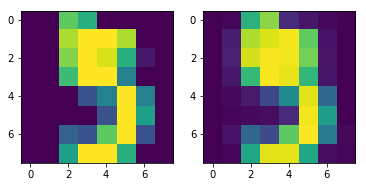

In [23]:
idx = 5
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

6


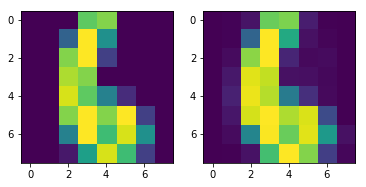

In [24]:
idx = 6
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

7


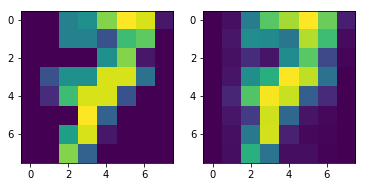

In [25]:
idx = 7
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

8


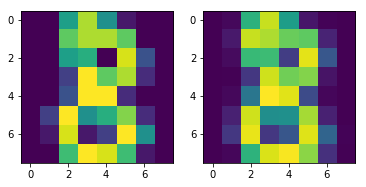

In [26]:
idx = 8
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

9


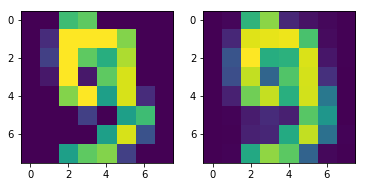

In [27]:
idx = 9
print(y[idx])
fig, subs = plt.subplots(nrows=1, ncols=2)
subs[0].imshow(X_sc[idx].reshape((8,8)))
subs[1].imshow(y_pred[idx].reshape((8,8)))

### plot output of GaussianKernel layer #1

1696/1797 [===========================>..] - ETA: 0s

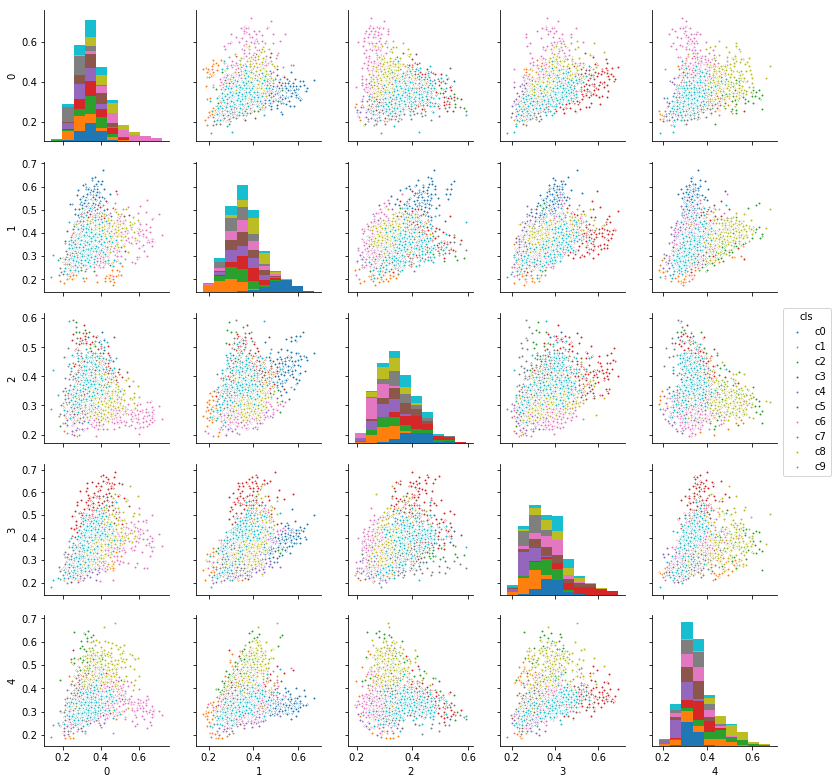

In [28]:
gk1_pred = models['model_gk1'].predict(X_sc, batch_size=32, verbose=1)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

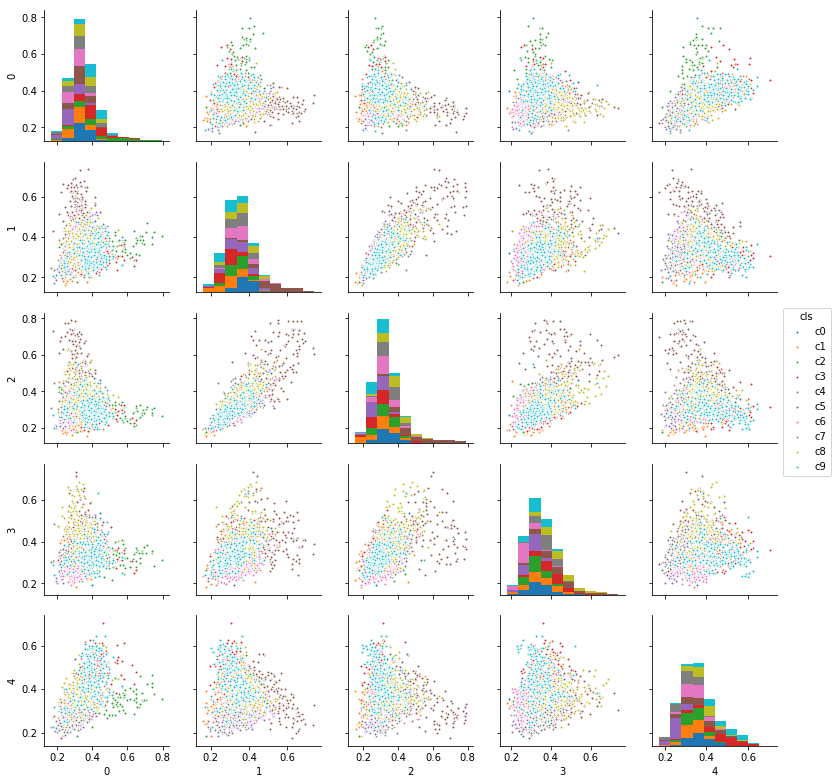

In [29]:
df = pd.DataFrame(gk1_pred[:,5:10])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

In [30]:
'''gamma of GaussianKernel layer #1'''
np.exp(models['model_gk1'].get_layer('gkernel1').get_weights()[1])

array([ 0.10847759], dtype=float32)

### show landmarks

In [31]:
wgt = model.get_layer('gkernel1').get_weights()[0]

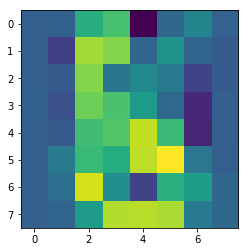

In [32]:
plt.imshow(wgt[0].reshape((8,8)))

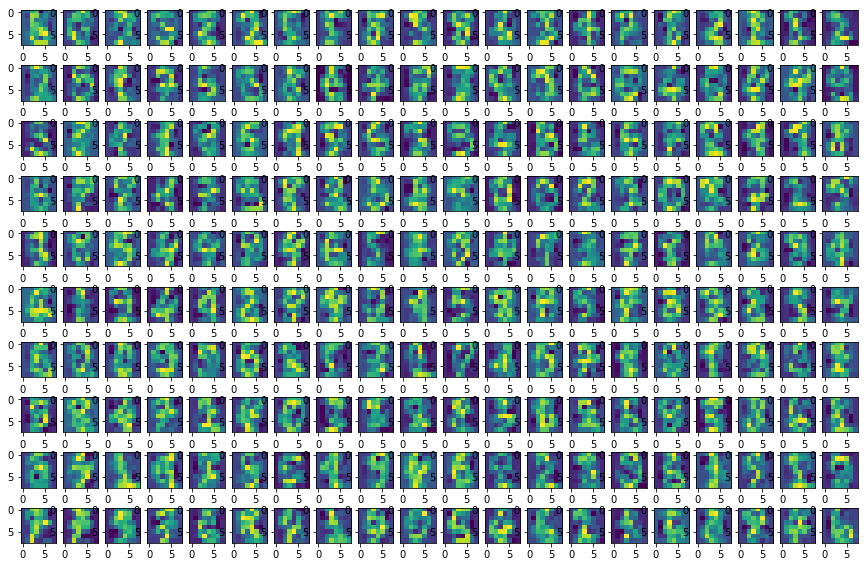

In [33]:
nrows=10
ncols=20
fig, subs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for ii in range(nrows):
    for jj in range(ncols):
        iplt = subs[ii,jj]
        img_array = wgt[ii*ncols+jj].reshape((8, 8))
        iplt.imshow(img_array)